# <p style="text-align: center;">A first simple LSTM network<br>for time series prediction
</p>

<p style="text-align: center;">
 by Prof. Dr.-Ing. Jürgen Brauer, http://www.juergenbrauer.org
</p>

## Table of Contents:

1. Generate some time series data
2. Plot the time series data
3. Prepare training data
4. Building and training the LSTM network model using Keras
5. Test prediction performance on train data
6. Long-term predictions
7. Experiments

## 1. Generate some time series data

In [104]:
# Experiment settings:
# Set EXP_NR to one of the following values: 1-5
EXP_NR = 5

if EXP_NR==1:    
    LOOK_BACK = 3
    NR_LSTM_CELLS = 1
    NR_TRAIN_EPOCHS = 300
    SCALE_TIME_SERIES = False
    BATCH_SIZE = 16
    REMEMBER_LAST_STATE = False
    
if EXP_NR==2:
    # Less training steps, but
    # scaling of time series    
    LOOK_BACK = 3
    NR_LSTM_CELLS = 1
    NR_TRAIN_EPOCHS = 100
    SCALE_TIME_SERIES = True
    BATCH_SIZE = 16
    REMEMBER_LAST_STATE = False
    
if EXP_NR==3:
    # Larger time window
    LOOK_BACK = 10
    NR_LSTM_CELLS = 1
    NR_TRAIN_EPOCHS = 100
    SCALE_TIME_SERIES = True
    BATCH_SIZE = 16
    REMEMBER_LAST_STATE = False
    
if EXP_NR==4:
    # 1 LSTM cell --> 5 LSTM cells
    LOOK_BACK = 10
    NR_LSTM_CELLS = 5
    NR_TRAIN_EPOCHS = 100
    SCALE_TIME_SERIES = True
    BATCH_SIZE = 16
    REMEMBER_LAST_STATE = False
    
if EXP_NR==5:
    LOOK_BACK = 30
    NR_LSTM_CELLS = 5
    NR_TRAIN_EPOCHS = 1000
    SCALE_TIME_SERIES = True
    BATCH_SIZE = 1
    REMEMBER_LAST_STATE = True
    
print("Using settings for EXP_NR:", EXP_NR)
print("\t LOOK_BACK =", LOOK_BACK)
print("\t NR_LSTM_CELLS =", NR_LSTM_CELLS)
print("\t NR_TRAIN_EPOCHS =", NR_TRAIN_EPOCHS)
print("\t SCALE_TIME_SERIES =", SCALE_TIME_SERIES)
print("\t BATCH_SIZE = ", BATCH_SIZE)
print("\t REMEMBER_LAST_STATE =", REMEMBER_LAST_STATE)

    
import numpy as np
from sklearn.preprocessing import MinMaxScaler

data_x = [x for x in np.arange(0.0, 100.0, 0.1)]
print("\nLength of data_x is", len(data_x))

time_series = [x/10.0+np.cos(x)+np.random.rand() for x in data_x]


if SCALE_TIME_SERIES:
    
    # Rescale time series such that values are in [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_time_series = scaler.fit_transform(np.array(time_series).reshape(-1,1))
    scaled_time_series = scaled_time_series.reshape(-1).tolist()
    time_series = scaled_time_series


print("Length of time_series is", len(time_series))
#print("time_series=", time_series)


Using settings for EXP_NR: 5
	 LOOK_BACK = 30
	 NR_LSTM_CELLS = 5
	 NR_TRAIN_EPOCHS = 1000
	 SCALE_TIME_SERIES = True
	 BATCH_SIZE =  1
	 REMEMBER_LAST_STATE = True

Length of data_x is 1000
Length of time_series is 1000


## 2. Plot the time series data

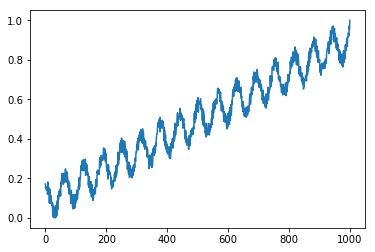

In [105]:
import matplotlib.pyplot as plt
plt.plot(time_series)
plt.show()

## 3. Prepare training data

For the training of the LSTM we need training samples of the form

    [value_t-2, value_t-1, value_t  ] --> value_t+1
    [value_t-1, value_t  , value_t+1] --> value_t+2
    [value_t  , value_t+1, value_t+2] --> value_t+3
    ...
    etc.


In [106]:
# define a helper function to convert a time series array
# into two NumPy arrays
# train_input (containing LOOK_BACK samples)
# and
# train_output (containing 1 prediction sample)

def split_into_train_samples(dataset, LOOK_BACK=1):
   train_input, train_output = [], []
   for i in range(len(dataset)-LOOK_BACK):
      a = dataset[i:i+LOOK_BACK]
      train_input.append(a)
      train_output.append(dataset[i + LOOK_BACK])
   return np.array(train_input), np.array(train_output)


# define how NumPy shall print matrices
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True) # do not use scientific "e"-notation

train_input, train_output = split_into_train_samples( time_series, LOOK_BACK)
print("train_input has shape", train_input.shape)
print("train_output has shape", train_output.shape)
print("train_input=", train_input)
print("train_output=", train_output)


train_input has shape (970, 30)
train_output has shape (970,)
train_input= [[0.17 0.15 0.15 ... 0.02 0.   0.05]
 [0.15 0.15 0.15 ... 0.   0.05 0.03]
 [0.15 0.15 0.14 ... 0.05 0.03 0.03]
 ...
 [0.79 0.84 0.78 ... 0.94 0.93 0.92]
 [0.84 0.78 0.83 ... 0.93 0.92 0.97]
 [0.78 0.83 0.81 ... 0.92 0.97 0.95]]
train_output= [0.03 0.03 0.06 0.   0.06 0.04 0.01 0.07 0.01 0.09 0.04 0.05 0.11 0.09
 0.13 0.13 0.14 0.11 0.14 0.13 0.11 0.18 0.16 0.2  0.2  0.23 0.19 0.23
 0.19 0.17 0.22 0.18 0.2  0.21 0.18 0.23 0.25 0.21 0.22 0.18 0.23 0.21
 0.21 0.2  0.16 0.15 0.19 0.12 0.17 0.17 0.15 0.12 0.13 0.09 0.07 0.14
 0.11 0.12 0.11 0.06 0.05 0.11 0.12 0.12 0.09 0.07 0.05 0.06 0.12 0.07
 0.12 0.09 0.09 0.14 0.13 0.1  0.11 0.12 0.16 0.16 0.14 0.2  0.15 0.18
 0.19 0.21 0.25 0.26 0.27 0.24 0.27 0.29 0.25 0.24 0.29 0.24 0.26 0.28
 0.29 0.24 0.29 0.3  0.22 0.27 0.23 0.27 0.25 0.26 0.22 0.23 0.22 0.17
 0.19 0.15 0.21 0.15 0.15 0.13 0.13 0.18 0.13 0.11 0.17 0.17 0.13 0.14
 0.09 0.1  0.1  0.14 0.15 0.12 0.15 0.13 0.1

## 4. Building and training the LSTM network model using Keras

Preparing the input to a LSTM can be a little bit tricky!

However, Jason Brownlee has a blog which provides a
gentle introduction into the topic:

"The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

    - Samples. One sequence is one sample. A batch is comprised of one or more samples.
    - Time Steps. One time step is one point of observation in the sample.
    - Features. One feature is one observation at a time step.
    
When defining the input layer of your LSTM network,
the network assumes you have 1 or more samples and
requires that you specify the number of time steps and
the number of features. You can do this by specifying
a tuple to the “input_shape” argument.

For example, the model below defines an input layer
that expects 1 or more samples, 50 time steps, and 2 features.

    model = Sequential()
    model.add(LSTM(32, input_shape=(50, 2)))
    model.add(Dense(1))"

Quotation source:
https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/

In [107]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# 1.
# Prepare training data for the Keras LSTM model
# Keras expects LSTM input to be 3-dimensional!
# Should have shape: [nr of samples, nr of time steps, nr of features]
#
train_input_reshaped  = train_input.reshape( (train_input.shape[0], LOOK_BACK, 1) )
print("Shape of train_input_reshaped is", train_input_reshaped.shape)
#print("train_input_reshaped=", train_input_reshaped)

# 2.
# Build the LSTM model using Keras
model = Sequential()
model.add( LSTM(
                NR_LSTM_CELLS,
                input_shape = (LOOK_BACK,1),
                stateful = REMEMBER_LAST_STATE,
                batch_input_shape=(BATCH_SIZE, LOOK_BACK, 1)
               )
         )
model.add( Dense(1) )
model.compile(loss='mean_squared_error', optimizer='adam')

# 3.
# Show the model architecture
model.summary()

# 4.
# Train the LSTM model
model.fit(train_input_reshaped,
          train_output,
          batch_size=BATCH_SIZE,
          shuffle=False,          
          epochs=NR_TRAIN_EPOCHS)

Shape of train_input_reshaped is (970, 30, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (1, 5)                    140       
_________________________________________________________________
dense_14 (Dense)             (1, 1)                    6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
970/970 [==============================] - 10s 10ms/step - loss: 0.0053
Epoch 2/1000
970/970 [==============================] - 7s 8ms/step - loss: 0.0055
Epoch 3/1000
970/970 [==============================] - 8s 8ms/step - loss: 0.0028
Epoch 4/1000
970/970 [==============================] - 8s 8ms/step - loss: 0.0018
Epoch 5/1000
970/970 [==============================] - 8s 9ms/step - loss: 0.0015
Epoch 6/1000
970/970 [==============================] - 8s 8ms/step - loss: 0

KeyboardInterrupt: 

## 5. Test prediction performance on train data

prediction has shape (970, 1)
train_output has shape (970,)


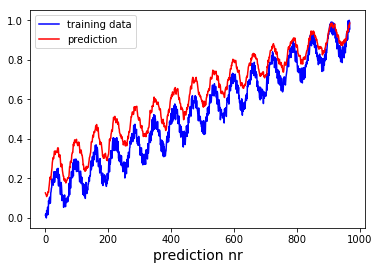

prediction_errors= [0.11 0.1  0.11 0.11 0.07 0.1  0.09 0.07 0.12 0.1  0.04 0.08 0.07 0.08
 0.09 0.13 0.13 0.07 0.08 0.07 0.09 0.06 0.1  0.1  0.11 0.14 0.09 0.08
 0.1  0.16 0.13 0.09 0.1  0.13 0.13 0.11 0.13 0.08 0.1  0.15 0.09 0.18
 0.17 0.1  0.09 0.11 0.15 0.17 0.17 0.1  0.08 0.1  0.14 0.18 0.12 0.13
 0.13 0.1  0.16 0.09 0.13 0.07 0.14 0.11 0.13 0.09 0.08 0.11 0.1  0.1
 0.09 0.12 0.1  0.09 0.1  0.05 0.06 0.14 0.05 0.11 0.14 0.12 0.07 0.06
 0.12 0.11 0.13 0.05 0.09 0.16 0.07 0.14 0.08 0.14 0.13 0.14 0.11 0.08
 0.12 0.16 0.13 0.13 0.13 0.08 0.14 0.09 0.14 0.15 0.16 0.17 0.1  0.09
 0.1  0.12 0.17 0.13 0.11 0.15 0.14 0.17 0.09 0.14 0.15 0.09 0.14 0.11
 0.07 0.15 0.1  0.06 0.13 0.12 0.14 0.1  0.11 0.11 0.08 0.09 0.09 0.08
 0.12 0.1  0.11 0.11 0.05 0.07 0.14 0.13 0.11 0.08 0.09 0.16 0.12 0.08
 0.1  0.14 0.12 0.09 0.12 0.08 0.14 0.13 0.09 0.19 0.13 0.08 0.11 0.15
 0.17 0.17 0.12 0.12 0.14 0.16 0.07 0.14 0.11 0.13 0.16 0.14 0.14 0.16
 0.09 0.16 0.11 0.1  0.13 0.1  0.09 0.12 0.11 0.14 0.15 0.1

In [97]:
prediction = model.predict(train_input_reshaped, batch_size=1)
print("prediction has shape", prediction.shape)
print("train_output has shape", train_output.shape)
#print(prediction)


plt.plot(train_output, label="training data", color="blue")
plt.plot(prediction, label="prediction", color="red")
plt.xlabel("prediction nr", fontsize=14)
plt.legend()
plt.show()


prediction_errors = \
   np.abs(prediction.reshape(prediction.shape[0]) - train_output)
mean_prediction_error = np.mean(prediction_errors)
print("prediction_errors=", prediction_errors)
print("mean_prediction_error=", mean_prediction_error)


## 6. Long-term predictions

In the previous experiment we always took LOOK_BACK many values and predicted the next value. E.g., we have the sales figures for the last LOOK_BACK=5 days and we want to predict the sales figures for the next day.

However, in some applications we would like to do long-term predictions. E.g., we have just LOOK_BACK=5 sales figures of the last 5 days and we want to predict the sales figures for the next two weeks.

What can we do? We could use our predicted values as input for the next prediction round!

First prediction round:

    sales_t-5, sales_t-4, sales_t-3, sales_t-2, sales_t-1 --> pred_sales_t

Second prediction round:

    sales_t-4, sales_t-3, sales_t-2, sales_t-1, pred_sales_t --> pred_sales_t+1

Third prediction round:

    sales_t-3, sales_t-2, sales_t-1, pred_sales_t, pred_sales_t+1 --> pred_sales_t+2
    
...

Let's try this approach!

### Making a single prediction

First we need to learn how to do a single prediction. Then we can prepare the input data in each new prediction step such that we include the last prediction values.

In [98]:
# 1. Prepare training data such that we can use
#    LOOK_BACK many last time steps for the prediction
#print("LOOK_BACK is", LOOK_BACK)
#train_input, train_output = split_into_train_samples( time_series, LOOK_BACK)

# 2. Prepare input for a single prediction
single_input = np.array( [time_series[i] for i in range(0,LOOK_BACK)] )
# LSTM expects input to be [samples, time steps, features]
single_input_reshaped = single_input.reshape(1,LOOK_BACK,1)
single_prediction = model.predict(single_input_reshaped)
ground_truth = time_series[LOOK_BACK]
print("single_prediction has type", type(single_prediction))
print("single_prediction=", single_prediction[0][0])
print("ground_truth=", ground_truth)


single_prediction has type <class 'numpy.ndarray'>
single_prediction= 0.12659463
ground_truth= 0.01425633086394535


### Using predicted values as input for the next prediction step

Now we want to follow the idea mentioned above and put the predicted value into the input vector for the next prediction step.

I will now try a long term prediction for 970 time steps.
Thereby I will use each predicted value for the next input.


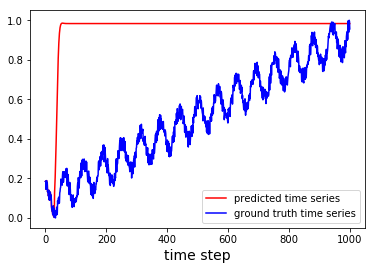

Len of predicted_time_series is 1000
Len of time_series_part is 1000
prediction_errors= [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.11 0.14 0.2  0.25 0.27 0.36 0.41 0.45 0.55 0.61 0.61 0.69
 0.71 0.75 0.78 0.84 0.86 0.82 0.83 0.82 0.82 0.78 0.8  0.8  0.8  0.82
 0.77 0.75 0.76 0.8  0.79 0.75 0.75 0.78 0.77 0.76 0.78 0.73 0.74 0.78
 0.73 0.81 0.82 0.78 0.76 0.78 0.81 0.85 0.87 0.83 0.8  0.82 0.85 0.9
 0.87 0.89 0.89 0.87 0.93 0.88 0.92 0.87 0.92 0.91 0.93 0.9  0.89 0.91
 0.89 0.89 0.88 0.9  0.89 0.87 0.88 0.82 0.81 0.87 0.78 0.82 0.83 0.82
 0.78 0.75 0.78 0.77 0.78 0.71 0.71 0.77 0.69 0.74 0.69 0.72 0.72 0.74
 0.72 0.69 0.71 0.75 0.73 0.73 0.74 0.7  0.75 0.7  0.74 0.75 0.77 0.8
 0.76 0.75 0.75 0.76 0.81 0.79 0.78 0.82 0.82 0.86 0.81 0.85 0.87 0.83
 0.87 0.86 0.81 0.88 0.84 0.8  0.85 0.84 0.86 0.83 0.84 0.84 0.81 0.81
 0.79 0.78 0.8  0.77 0.77 0.77 0.7  0.69 0.74 0.73 0.71 0.68 0.67 

In [99]:
NR_PREDICTION_STEPS = len(time_series)-LOOK_BACK
#NR_PREDICTION_STEPS = 1000
print("I will now try a long term prediction for",
      NR_PREDICTION_STEPS, "time steps.")
print("Thereby I will use each predicted value "
      "for the next input.")

# 1.
# For the very first prediction vector
# we need some input data:
# here we take the first LOOK_BACK time steps
# from the ground truth data
predicted_time_series = [time_series[i] for i in range(0,LOOK_BACK)]

# 2. 
# now lets predict a new value for each coming
# time step based on past predicted values
model.reset_states()
for prediction_step in range(0,NR_PREDICTION_STEPS):

    # 2.1 
    # prepare the last LOOK_BACK values of the predicted
    # time series as input vector for the next prediction
    N = len(predicted_time_series)
    single_input_as_np_array =\
       np.array( predicted_time_series[N-LOOK_BACK:N] )
    #print(single_input_as_np_array)
    
    # 2.2
    # LSTM expects input to be 3D dimensional!
    # It shall have the shape: [samples, time steps, features]
    single_input_reshaped = single_input_as_np_array.reshape(1,LOOK_BACK,1)
    single_prediction = model.predict(single_input_reshaped)
    
    # 2.3
    # get the predicted value as a scalar
    # Note: Keras provides us the prediction as a 2D NumPy matrix
    #       - for each input vector a prediction row
    #       - for each of the predicted values a column
    predicted_value = single_prediction[0][0]
    #print("predicted_value=", predicted_value)
    
    # 2.4
    # save the predicted value
    predicted_time_series.append( predicted_value )
    
    
# 3.
# plot the predicted time series and
# the ground truth time series for comparison    
plt.plot(predicted_time_series, label="predicted time series", color="red")
time_series_part = time_series[0:NR_PREDICTION_STEPS+LOOK_BACK]
plt.plot(time_series_part, label="ground truth time series", color="blue")
plt.xlabel("time step", fontsize=14)
plt.legend()
plt.show()


# 4.
# now compute the difference between predicted values
# and ground truth values
print("Len of predicted_time_series is", len(predicted_time_series))
print("Len of time_series_part is", len(time_series_part))
prediction_errors = np.abs(np.array(predicted_time_series) - np.array(time_series_part))
mean_prediction_error = np.mean(prediction_errors)
print("prediction_errors=", prediction_errors)
print("mean_prediction_error=", mean_prediction_error)    
    
    


# 7. Experiments

#### Experiment #1:
 - Short-term prediction: very rough form of curve predicted
 - Long-term prediction: does not work

#### Experiment #2: scaling of time series
 - Short-term prediction: much better: OK!
 - Long-term prediction: does not work
 
#### Experiment #3: larger time window
 - Short-term prediction: as in Exp2
 - Long-term prediction: as in Exp2

#### Experiment #4: more LSTM cells
 - Short-term prediction: as in Exp2
 - Long-term prediction: as in Exp2
 
#### Experiment #5: even larger time window &  even more LSTM cells
 - Short-term prediction: as in Exp2
 - Long-term prediction: as in Exp2
   


   
#### Experiment conclusions:

- Exp1 vs. Exp2 shows: scaling of time series is important!
- Exp3 shows: just a larger time windows does not help
- Exp4 shows: just more LSTM cells does not help 

